In [1]:
'''
******************************************************************************
  CSE-512-Machine Learning HW2 Question 3
  Name: Rishabh Goel
  SBU Id : 112714848
  Email Id: rishabh.goel@stonybrook.edu
*******************************************************************************
'''

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import multiprocessing
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hw2-predict-wine-goodness-from-review/valLabels.csv
/kaggle/input/hw2-predict-wine-goodness-from-review/testData_new.csv
/kaggle/input/hw2-predict-wine-goodness-from-review/trainLabels.csv
/kaggle/input/hw2-predict-wine-goodness-from-review/featureTypes.txt
/kaggle/input/hw2-predict-wine-goodness-from-review/valData.csv
/kaggle/input/hw2-predict-wine-goodness-from-review/trainData.csv


In [2]:
def load_data(file):
    return np.array(pd.read_csv(file, header=None, index_col=0))

path = '/kaggle/input/hw2-predict-wine-goodness-from-review/'
files = [path+'trainData.csv', 
         path+'trainLabels.csv',
         path+'valData.csv',
         path+'valLabels.csv',
         path+'testData_new.csv',
        ]

with multiprocessing.Pool() as pool:
    train_x, train_y, val_x, val_y, test_x = pool.map(load_data, files)

features = list(pd.read_csv(path+'featureTypes.txt', header=None)[0])

print(f'trainData has {train_x.shape[0]} rows and {train_x.shape[1]} columns.')
print(f'trainLabels has {train_y.shape[0]} rows and {train_y.shape[1]} columns.')
print(f'valData has {val_x.shape[0]} rows and {val_x.shape[1]} columns.')
print(f'valLabels has {val_y.shape[0]} rows and {val_y.shape[1]} columns.')
print(f'testData has {test_x.shape[0]} rows and {test_x.shape[1]} columns.')

trainData has 5000 rows and 3000 columns.
trainLabels has 5000 rows and 1 columns.
valData has 5000 rows and 3000 columns.
valLabels has 5000 rows and 1 columns.
testData has 4749 rows and 3000 columns.


**Question 3.1** Implement a function to perform Ridge Regression with LOOCV

In [3]:
def ridgeReg(X, y, lamda):
    
    #k*n data matrix
    k, n = X.shape  
    X_bar = np.vstack((X, np.ones(shape=(1,n))))
    
    '''
        1 0 0 · · 0
        0 1 0 · · 0
        . . . . . 0
    Ī = . . . . . 0
        0 · · · 1 0
        0 0 0 0 0 0
    ''' 
    I = np.identity(k)
    I_bar = np.hstack((I, np.zeros((k,1))))
    I_bar = np.vstack((I_bar, np.zeros((1,k+1))))
    
    C = X_bar@X_bar.T + lamda * I_bar # C = (X̄.X̄ᵀ) + λĪ
    d = X_bar@y  # d = X̄.y
    U,s,V = np.linalg.svd(C) # inverse using SVD decomposition
    C_inv = np.transpose(V) @ np.diag(1/s) @ np.transpose(U)
    #C_inv = np.linalg.inv(C) # C⁻¹
    w_bar = C_inv@d  # w̅ = C⁻¹.(X̄.y)
    
    w = w_bar[:k,:]  # k*1 parameter vector
    b = w_bar[k]  # bias term
    obj = lamda * (w.T@w)[0,0] + np.sum(np.square((X.T@w)+b-y)) # obj = λ∥w∥² + ∑ᵢ₌₁ₜₒₙ(xᵢᵀw + b − yᵢ)²
    
    cv_errors = []
    for i in range(n):
        y_i = y[i,0]
        X_bar_i = X_bar[:,i]
        X_bar_i.shape = (np.size(X_bar_i),1)
        # From 2.5, we use the equation for leave-one-out error
        num = w_bar.T@X_bar_i - y_i  # w̅ᵀxᵢ − yᵢ
        den = 1 - np.dot(X_bar_i.T, C_inv@X_bar_i)  # 1 − x̄ᵀᵢC⁻¹x̄ᵢ
        cv_errors_i = num[0,0]/den[0,0] # w̅ᵀᵢx̄ᵢ − yᵢ = (w̅ᵀxᵢ − yᵢ)/(1 − x̄ᵀᵢC⁻¹x̄ᵢ)
        cv_errors.append(cv_errors_i)
        
    return (w, b, obj, cv_errors)

In [4]:
# common RMSE function for 1 or 2 arguments
def RMSE(*args):
    if len(args)==1:
        return np.sqrt((args[0].T@args[0])/args[0].size)
    else:
        return np.sqrt(np.mean((args[0]-args[1])**2))

**Question 3.2.1** Solve Ridge to predict the number of points a Wine will receive. Run Ridge on the training
set, with λ = 0.01, 0.1, 1, 10, 100, 1000. At each solution, record the root-mean-squared-error (RMSE)
on training, validation and leave-one-out-cross-validation data.

In [14]:
lambdas = [0.01, 0.1, 1, 10, 100, 1000]
rms_train = {}
rms_val = {}
rms_loocv = {}
for lamda in lambdas :
    # RMSE on leave-one-out-cross-validation data.
    w, b, obj, cv_errors = ridgeReg(train_x.T, train_y, lamda)
    rms_loocv[lamda] = RMSE(np.array(cv_errors))
    
    # RMSE on train data.
    train_y_pred   = train_x@w + b
    rms_train[lamda] = RMSE(train_y,train_y_pred)
    
    # RMSE on validation data.
    val_y_pred   =  val_x@w + b
    rms_val[lamda] = RMSE(val_y,val_y_pred)
print(f'lambda \t train_rmse \t\t val_rmse \t\t loocv_error')
for l in lambdas:
    print(f'{l} \t {rms_train[l]} \t {rms_val[l]} \t {rms_loocv[l]}')

lambda 	 train_rmse 		 val_rmse 		 loocv_error
0.01 	 1.1205188247625317 	 2.579186825708291 	 2.580103521790369
0.1 	 1.223811965696008 	 2.1574812686461002 	 2.1821064991210806
1 	 1.5780360753182137 	 1.9967715113690747 	 2.0094740608896973
10 	 2.189953395751608 	 2.347705513916257 	 2.320135165798057
100 	 2.9709419656108147 	 3.0171052386646875 	 2.9965727187353264
1000 	 3.331612592153038 	 3.345415090847551 	 3.3353399803872215


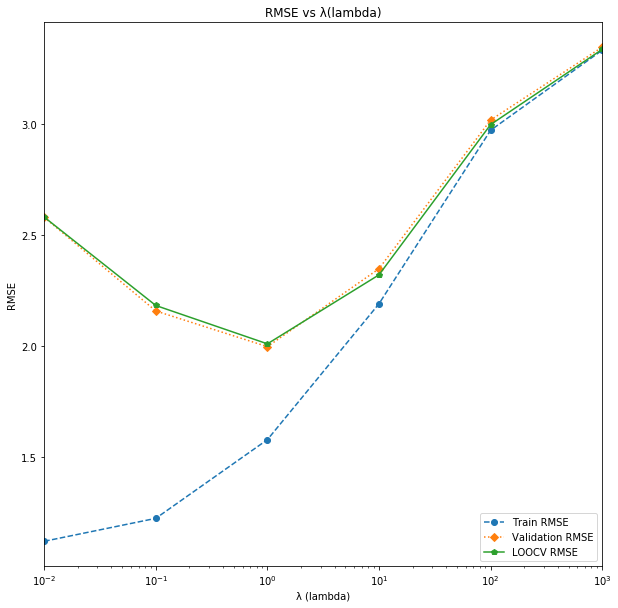

In [19]:
df = pd.DataFrame({'Train RMSE': rms_train, 'Validation RMSE': rms_val, 'LOOCV RMSE': rms_loocv})
ax = df.plot()
markers = ['o','D','p']
linestyles = ['--',':','-']
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])
    line.set_linestyle(linestyles[i])
ax.set_xlabel("λ (lambda)")
ax.set_ylabel("RMSE")
ax.set_title("RMSE vs λ(lambda)")
plt.legend(loc=4)
plt.xscale('log',basex=10) 
plt.rcParams['figure.figsize'] = [15, 10]

**Question 3.2.2** What λ achieve the best best LOOCV performance? For the model using this λ, report the
objective value, the sum of square errors (on training data), the value of the regularization term.

In [7]:
# LOOCV RMSE is lowest at λ = 1 as is evident from above plot
lambda0 = 1.0
w0, b0, obj0, cv_errors0 = ridgeReg(train_x.T, train_y, lambda0)

# obj₀ = λ₀∥w₀∥² + ∑ᵢ₌₁ₜₒₙ(xᵢᵀw₀ + b₀ − yᵢ)²
# reg₀ = λ₀∥w₀∥²
# sse₀ = ∑ᵢ₌₁ₜₒₙ(xᵢᵀw₀ + b₀ − yᵢ)² = obj₀ - reg₀
reg0 = lambda0*(w0.T@w0)[0,0]
sse0 = obj0 - reg0  

print(f' Objective Value : {obj0}\n Sum of Square errors : {sse0}\n Regularization Term : {reg0}')

 Objective Value : 17200.940568722985
 Sum of Square errors : 12450.989275028554
 Regularization Term : 4749.951293694429


**Question 3.2.3 ** Using the model that you computed using λ that achieves best LOOCV performance, list the top 10 most important features and the top 10 least important features. Comment if the weights make sense intuitively.

In [8]:
features_top_10 = sorted(range(len(w0)), key = lambda sub: w0[sub], reverse=True)[:10]
features_bot_10 = sorted(range(len(w0)), key = lambda sub: w0[sub])[:10]

print('*'*50)
print(f' Most important 10 features')
print('*'*50)
print(f'index \t feature \t \t weight')
print('-'*50)
for i in features_top_10:
    print(i, '\t', features[i] ,' '*(20-len(features[i])), w0[i,0])
print('\n')
print('*'*50)
print(f' Least important 10 features')
print('*'*50)
print(f'index \t feature \t \t weight')
print('-'*50)
for i in features_bot_10:
    print(i, '\t', features[i] ,' '*(20-len(features[i])), w0[i,0])

**************************************************
 Most important 10 features
**************************************************
index 	 feature 	 	 weight
--------------------------------------------------
184 	 infused               6.998953378195608
754 	 pineapple orange      5.663260515332581
773 	 red                   5.636523454589906
1272 	 sweet black           5.194727564868572
642 	 little heavy          5.128505094494926
186 	 new french            5.078891240478356
1924 	 future                4.84825814467564
2835 	 currant cola          4.786819319038614
2068 	 cocktail              4.735953090413375
781 	 price dry             4.690847637298177


**************************************************
 Least important 10 features
**************************************************
index 	 feature 	 	 weight
--------------------------------------------------
2368 	 flavors nice          -5.280346413179132
1486 	 soft                  -4.643603645818644
2821 	 low alcohol    

The weights make sense . The top 10 features have the highest weights (the most important ones having higher weight). The least important 10 features have the lowest weights ( the least important ones having lower weight). Thus, the value of the weight gives an intuition about their importance.

**Question 3.2.4 **  Use your model to predict the points for the reviews in test data. Save
the predicted values on a CSV file predTestLabels.csv (see 4.2 for the format). The order of
predicted values should correspond to the order of the reviews in testData.csv (counting starts
from 0).


In [9]:
features_top = sorted(range(len(w0)), key = lambda sub: w0[sub], reverse=True)
train_x_top = train_x[:,features_top]
val_x_top = val_x[:,features_top]
test_x_top = test_x[:,features_top]

#np.where(~val_x.any(axis=0))[0] # checking for zero value columns
#plt.imshow(train_x[:,features_top], cmap='hot', interpolation='nearest')
#plt.show() # plotting heatmap
#np.unique(train_x) #132 unique values
#for i in range(1,5):
#    print(np.nonzero(train_x[:,i])) #checking non zero values per column
#minval_train = 1-np.max(train_x_top[np.nonzero(train_x_top)])
#minval_val = 1-np.max(val_x_top[np.nonzero(val_x_top)])
#minval_test = 1-np.max(test_x_top[np.nonzero(test_x_top)])
                                 
#since most of the values are zero, applying log(1+x) to the data.    
train_x_log = np.log(1+train_x_top)
val_x_log = np.log(1+val_x_top)
test_x_log = np.log(1+test_x_top)

#print(train_x_log.mean(axis=1),val_x_log.mean(axis=1),test_x_log.mean(axis=1))
#np.mean(test_x_top[np.nonzero(test_x_top)])
#min  = 0.12 across all
#max =  0.72 for train, 0.65
#mean = 0.197 across all
#np.vstack((train_y,val_y)).shape

trying lambda values between 0.1 and 1, then 0.5 and 0.9 , then 0.1 and 0.5, using top 1500 features - somewhat useful
trying lambda values between 0.35 and 0.55, then 0.55 and 0.85 using top 2000 features - not useful
trying lambda values between 0.35 and 0.55, then 0.55 and 0.85 using top 2500 features - not useful
trying lambda values between 0.35 and 0.55, then 0.55 and 0.85 using top 1750 features - not useful

In [12]:
lambdas = np.arange(0.65, 0.75, 0.01)
rms_train = {}
rms_val = {}
rms_loocv = {}
for lamda in lambdas :
    # RMSE on leave-one-out-cross-validation data.
    w, b, obj, cv_errors =  ridgeReg(np.vstack((train_x_log,val_x_log)).T, np.vstack((train_y,val_y)), lamda)
    rms_loocv[lamda] = RMSE(np.array(cv_errors))
    
    # RMSE on train data.
    train_y_pred   = train_x_log@w + b
    rms_train[lamda] = RMSE(train_y,train_y_pred)
    
    # RMSE on validation data.
    val_y_pred   =  val_x_log@w + b
    rms_val[lamda] = RMSE(val_y,val_y_pred)
print(f'lambda \t train_rmse \t\t val_rmse \t\t loocv_error')
for l in lambdas:
    print(f'{l} \t {rms_train[l]} \t {rms_val[l]} \t {rms_loocv[l]}')

lambda 	 train_rmse 		 val_rmse 		 loocv_error
0.65 	 1.5849671017577363 	 1.5629367468508262 	 1.8892073085506857
0.66 	 1.586504943286134 	 1.564586809121593 	 1.8891633572039386
0.67 	 1.5880323474446352 	 1.566226492904336 	 1.8891350578217838
0.68 	 1.5895494579472191 	 1.5678559239672192 	 1.8891218205894407
0.6900000000000001 	 1.591056416036289 	 1.5694752266332914 	 1.889123082632492
0.7000000000000001 	 1.5925533605071756 	 1.5710845237383082 	 1.8891383065088745
0.7100000000000001 	 1.5940404277358489 	 1.5726839365957659 	 1.8891669788010337
0.7200000000000001 	 1.5955177517080883 	 1.5742735849697562 	 1.889208608801836
0.7300000000000001 	 1.5969854640500798 	 1.5758535870533923 	 1.889262727284942
0.7400000000000001 	 1.5984436940627755 	 1.577424059452594 	 1.8893288853563064


'ridge results'

1. lambdas = np.arange(0.05, 0.95, 0.1)
lambda 	 train_rmse 		 val_rmse 		 loocv_error
0.05 	 1.6046137773611917 	 1.5877931891071548 	 2.0054165240719133
0.15000000000000002 	 1.6037195642917668 	 1.5840805870497878 	 1.9451211701053366
0.25000000000000006 	 1.609130583380727 	 1.589103899150963 	 1.9172459536454498
0.35000000000000003 	 1.6168232588357594 	 1.597128600478682 	 1.9025268674363394
0.45000000000000007 	 1.6254029503407201 	 1.6063398198901988 	 1.8946094410523593
0.5500000000000002 	 1.634276549300964 	 1.6159895498086463 	 1.89066033572717
0.6500000000000001 	 1.643165718361756 	 1.6257290443486025 	 1.8892073085506846
0.7500000000000002 	 1.6519336860716956 	 1.635385030335106 	 1.8894066533755176
0.8500000000000002 	 1.6605131174730603 	 1.6448694770992496 	 1.8907402830608346

2. lambdas = np.arange(0.55, 0.85, 0.05)
lambda 	 train_rmse 		 val_rmse 		 loocv_error
0.55 	 1.6342765493007156 	 1.6159895498083325 	 1.890660335726852
0.6000000000000001 	 1.6387299346328665 	 1.6208616100365991 	 1.8896845882682543
0.6500000000000001 	 1.643165718361756 	 1.6257290443486025 	 1.8892073085506846
0.7000000000000002 	 1.647570183030469 	 1.6305743529873427 	 1.889138306509035
0.7500000000000002 	 1.6519336860716956 	 1.635385030335106 	 1.8894066533755176
0.8000000000000003 	 1.6562495206653602 	 1.640152167236323 	 1.889955831264713

3. lambdas = np.arange(0.65, 0.75, 0.01)
lambda 	 train_rmse 		 val_rmse 		 loocv_error
0.65 	 1.6431657183619586 	 1.6257290443483468 	 1.8892073085504193
0.66 	 1.6440494756068105 	 1.6267003378255116 	 1.889163357203895
0.67 	 1.6449318796050596 	 1.6276706176368714 	 1.8891350578213462
0.68 	 1.6458128486813062 	 1.6286397781866804 	 1.889121820590393
0.6900000000000001 	 1.6466923067639314 	 1.6296077207379436 	 1.8891230826326095
0.7000000000000001 	 1.6475701830305616 	 1.6305743529872334 	 1.8891383065097567
0.7100000000000001 	 1.648446411579344 	 1.6315395886498834 	 1.8891669788009053
0.7200000000000001 	 1.649320931114297 	 1.6325033470905936 	 1.8892086088016327
0.7300000000000001 	 1.6501936846746326 	 1.6334655529772293 	 1.88926272728481
0.7400000000000001 	 1.6510646193590914 	 1.6344261359559016 	 1.8893288853553307

In [11]:
lambda_final = 0.68
w_final, b_final, obj_final, cv_errors_final = ridgeReg(np.vstack((train_x_log, val_x_log)).T, 
                                                    np.vstack((train_y,val_y)), lambda_final)
    
print(RMSE(np.array(cv_errors_final)))
test_pred_y = (test_x_log@w_final) + b_final
predictions_df = pd.DataFrame(test_pred_y)
predictions_df.index.rename('Id', inplace=True)
predictions_df.to_csv('predTestLabels.csv', index=True, header=['Expected'])

reg_final = lambda_final*(w_final.T@w0)[0,0]
sse_final = obj_final - reg_final  

print(f' Objective Value : {obj_final}\n Sum of Square errors : {sse_final}\n Regularization Term : {reg_final}')

1.8891218205894407
 Objective Value : 30951.90761683126
 Sum of Square errors : 30325.486333903857
 Regularization Term : 626.421282927404
